# Image GAN

This example builds a Generative Adversarial Network (GAN) using convolutional layers in the discriminator and generator.

In practice GANs are now used fairly rarely, because they're quite tricky to train stably. Modern applications tend to use [score-based diffusions](score_based_diffusion.ipynb) instead. Nonetheless, here's an example for how we might set up a GAN in Equinox.

This example is an implementation based on the paper: Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks.

!!! cite "Reference"

    [arXiv link](https://arxiv.org/abs/1511.06434)

    ```bibtex
    @misc{radford2015unsupervised,
      author = {Radford, Alec and Metz, Luke and Chintala, Soumith},
      title = {Unsupervised Representation Learning with Deep Convolutional Generative
      Adversarial Networks},
      url = {http://arxiv.org/abs/1511.06434},
      year = 2015
    }
    ```

In [1]:
from collections.abc import Callable

import equinox as eqx
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import optax

# We'll use PyTorch to load the dataset.
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
# Hyperparameters
lr = 0.0002
beta1 = 0.5
beta2 = 0.999
batch_size = 32
num_steps = 100000
image_size = (64, 64, 1)
height, width, channels = image_size
latent_size = 100

In [8]:
# Load the MNIST dataset using torchvision
transform = transforms.Compose(
    [
        transforms.Resize((height, width)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)

data = torchvision.datasets.MNIST(root="./data", transform=transform, download=True)

dataloader = torch.utils.data.DataLoader(
    data, batch_size=batch_size, shuffle=True, num_workers=2
)

Let's load some example data, and see some sample MNIST digits.

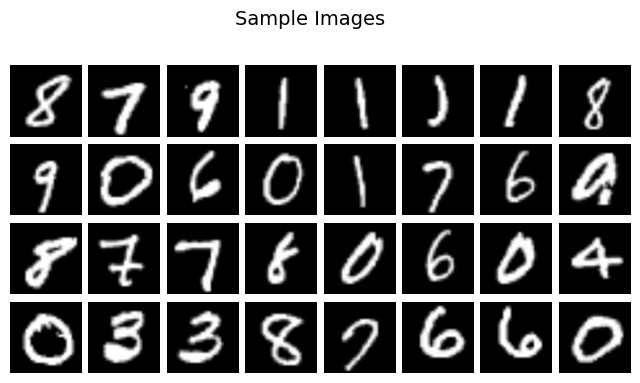

In [9]:
images, labels = next(iter(dataloader))

plot_sample = images.permute(0, 2, 3, 1)

fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(8, 4))
fig.suptitle("Sample Images", y=1.02, fontsize=14)

for ax, image in zip(sum(axes.tolist(), []), plot_sample):
    ax.imshow(image, cmap="gray")
    ax.set_axis_off()

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

Next, it's time to build the interesting part: the model! Let's start with the generator:

In [10]:
class Generator(eqx.Module):
    layers: list[eqx.nn.ConvTranspose2d | eqx.nn.BatchNorm | Callable]

    def __init__(
        self,
        input_shape: int,
        output_shape: tuple[int, int, int],
        key: jr.PRNGKey,
    ):
        keys = jr.split(key, 5)

        height, width, channels = output_shape

        self.layers = [
            eqx.nn.ConvTranspose2d(
                in_channels=input_shape,
                out_channels=width * 8,
                kernel_size=4,
                stride=1,
                padding=0,
                use_bias=False,
                key=keys[0],
            ),
            eqx.nn.BatchNorm(input_size=width * 8, axis_name="batch"),
            jax.nn.relu,
            eqx.nn.ConvTranspose2d(
                in_channels=width * 8,
                out_channels=width * 4,
                kernel_size=4,
                stride=2,
                padding=1,
                use_bias=False,
                key=keys[1],
            ),
            eqx.nn.BatchNorm(input_size=width * 4, axis_name="batch"),
            jax.nn.relu,
            eqx.nn.ConvTranspose2d(
                in_channels=width * 4,
                out_channels=width * 2,
                kernel_size=4,
                stride=2,
                padding=1,
                use_bias=False,
                key=keys[2],
            ),
            eqx.nn.BatchNorm(input_size=width * 2, axis_name="batch"),
            jax.nn.relu,
            eqx.nn.ConvTranspose2d(
                in_channels=width * 2,
                out_channels=width,
                kernel_size=4,
                stride=2,
                padding=1,
                use_bias=False,
                key=keys[3],
            ),
            eqx.nn.BatchNorm(input_size=width, axis_name="batch"),
            jax.nn.relu,
            eqx.nn.ConvTranspose2d(
                in_channels=width,
                out_channels=channels,
                kernel_size=4,
                stride=2,
                padding=1,
                use_bias=False,
                key=keys[4],
            ),
            jax.nn.tanh,
        ]

    def __call__(self, x, state):
        for layer in self.layers:
            if isinstance(layer, eqx.nn.BatchNorm):
                x, state = layer(x, state)
            else:
                x = layer(x)

        return x, state

And now the discriminator:

In [11]:
class Discriminator(eqx.Module):
    layers: list[eqx.nn.Conv2d | eqx.nn.PReLU | eqx.nn.BatchNorm | Callable]

    def __init__(
        self,
        input_shape: tuple[int, int, int],
        key: jr.PRNGKey,
    ):
        keys = jr.split(key, 5)

        height, width, channels = input_shape

        self.layers = [
            eqx.nn.Conv2d(
                in_channels=channels,
                out_channels=width,
                kernel_size=4,
                stride=2,
                padding=1,
                use_bias=False,
                key=keys[0],
            ),
            eqx.nn.PReLU(0.2),
            eqx.nn.Conv2d(
                in_channels=width,
                out_channels=width * 2,
                kernel_size=4,
                stride=2,
                padding=1,
                use_bias=False,
                key=keys[1],
            ),
            eqx.nn.BatchNorm(width * 2, axis_name="batch"),
            eqx.nn.PReLU(0.2),
            eqx.nn.Conv2d(
                in_channels=width * 2,
                out_channels=width * 4,
                kernel_size=4,
                stride=2,
                padding=1,
                use_bias=False,
                key=keys[2],
            ),
            eqx.nn.BatchNorm(width * 4, axis_name="batch"),
            eqx.nn.PReLU(0.2),
            eqx.nn.Conv2d(
                in_channels=width * 4,
                out_channels=width * 8,
                kernel_size=4,
                stride=2,
                padding=1,
                use_bias=False,
                key=keys[3],
            ),
            eqx.nn.BatchNorm(width * 8, axis_name="batch"),
            eqx.nn.PReLU(0.2),
            eqx.nn.Conv2d(
                in_channels=width * 8,
                out_channels=1,
                kernel_size=4,
                stride=1,
                padding=0,
                use_bias=False,
                key=keys[4],
            ),
        ]

    def __call__(self, x, state):
        for layer in self.layers:
            if isinstance(layer, eqx.nn.BatchNorm):
                x, state = layer(x, state=state)
            else:
                x = layer(x)

        return x, state

Next, we set up our training procedure: how to compute gradients with respect to both our generator and discriminator, and how to make a step of training. Settle in, this takes quite a lot of code to write down!

In [12]:
@eqx.filter_value_and_grad(has_aux=True)
def compute_grads_discriminator(
    discriminator,
    generator,
    fake_labels,
    real_batch,
    real_labels,
    discriminator_state,
    generator_state,
    key,
):
    key, subkey = jr.split(key)
    noise = jr.normal(subkey, (batch_size, latent_size, 1, 1))

    fake_batch, generator_state = jax.vmap(
        generator, axis_name="batch", in_axes=(0, None), out_axes=(0, None)
    )(noise, generator_state)

    pred_y, discriminator_state = jax.vmap(
        discriminator, axis_name="batch", in_axes=(0, None), out_axes=(0, None)
    )(fake_batch, discriminator_state)
    loss1 = optax.sigmoid_binary_cross_entropy(pred_y, fake_labels).mean()

    pred_y, discriminator_state = jax.vmap(
        discriminator, axis_name="batch", in_axes=(0, None), out_axes=(0, None)
    )(real_batch, discriminator_state)
    loss2 = optax.sigmoid_binary_cross_entropy(pred_y, real_labels).mean()

    loss = (loss1 + loss2) / 2

    return loss, (discriminator_state, generator_state, key)


@eqx.filter_value_and_grad(has_aux=True)
def compute_grads_generator(
    generator, discriminator, real_labels, discriminator_state, generator_state, key
):
    key, subkey = jr.split(key)
    noise = jr.normal(subkey, (batch_size, latent_size, 1, 1))

    fake_batch, generator_state = jax.vmap(
        generator, axis_name="batch", in_axes=(0, None), out_axes=(0, None)
    )(noise, generator_state)

    pred_y, discriminator_state = jax.vmap(
        discriminator, axis_name="batch", in_axes=(0, None), out_axes=(0, None)
    )(fake_batch, discriminator_state)
    loss = optax.sigmoid_binary_cross_entropy(pred_y, real_labels).mean()

    return loss, (discriminator_state, generator_state, key)


@eqx.filter_jit
def step_discriminator(
    discriminator: Discriminator,
    generator: Generator,
    real_batch: jnp.ndarray,
    discriminator_optimizer: optax.GradientTransformation,
    discriminator_opt_state: optax.OptState,
    generator_state: eqx.nn.State,
    discriminator_state: eqx.nn.State,
    key: jr.PRNGKey,
):
    fake_labels = jnp.zeros(batch_size)
    real_labels = jnp.ones(batch_size)

    (
        (
            loss,
            (discriminator_state, generator_state, key),
        ),
        grads,
    ) = compute_grads_discriminator(
        discriminator,
        generator,
        fake_labels,
        real_batch,
        real_labels,
        discriminator_state,
        generator_state,
        key,
    )

    updates, opt_state = discriminator_optimizer.update(grads, discriminator_opt_state)
    discriminator = eqx.apply_updates(discriminator, updates)

    return loss, discriminator, opt_state, generator_state, discriminator_state, key


@eqx.filter_jit
def step_generator(
    generator: Generator,
    discriminator: Discriminator,
    generator_optimizer: optax.GradientTransformation,
    generator_opt_state: optax.OptState,
    discriminator_state: eqx.nn.State,
    generator_state: eqx.nn.State,
    key: jr.PRNGKey,
):
    real_labels = jnp.ones(batch_size)

    (
        (
            loss,
            (discriminator_state, generator_state, key),
        ),
        grads,
    ) = compute_grads_generator(
        generator, discriminator, real_labels, discriminator_state, generator_state, key
    )

    updates, opt_state = generator_optimizer.update(grads, generator_opt_state)
    generator = eqx.apply_updates(generator, updates)

    return loss, generator, opt_state, discriminator_state, generator_state, key


def train(
    generator: Generator,
    discriminator: Discriminator,
    generator_optimizer: optax.GradientTransformation,
    discriminator_optimizer: optax.GradientTransformation,
    generator_opt_state: optax.OptState,
    discriminator_opt_state: optax.OptState,
    generator_state: eqx.nn.State,
    discriminator_state: eqx.nn.State,
    data_loader: torch.utils.data.DataLoader,
    num_steps: int,
    key: jr.PRNGKey,
    print_every: int = 1000,
):
    generator_losses = []
    discriminator_losses = []

    def infinite_trainloader():
        while True:
            yield from data_loader

    for step, batch in zip(range(num_steps), infinite_trainloader()):
        images, labels = batch

        (
            discriminator_loss,
            discriminator,
            discriminator_opt_state,
            generator_state,
            discriminator_state,
            key,
        ) = step_discriminator(
            discriminator,
            generator,
            images.numpy(),
            discriminator_optimizer,
            discriminator_opt_state,
            generator_state,
            discriminator_state,
            key,
        )

        (
            generator_loss,
            generator,
            generator_opt_state,
            discriminator_state,
            generator_state,
            key,
        ) = step_generator(
            generator,
            discriminator,
            generator_optimizer,
            generator_opt_state,
            discriminator_state,
            generator_state,
            key,
        )

        generator_losses.append(generator_loss)
        discriminator_losses.append(discriminator_loss)

        if (step % print_every) == 0 or step == num_steps - 1:
            print(
                f"Step: {step}/{num_steps}, Generator loss: {generator_loss}, "
                f"Discriminator loss: {discriminator_loss}"
            )

    return (
        generator,
        discriminator,
        generator_state,
        discriminator_state,
        generator_losses,
        discriminator_losses,
        key,
    )

Alright, now let's hit go! Here we initialise our models and then let them train.

In [15]:
key = jr.PRNGKey(2003)

key, gen_key, disc_key = jr.split(key, 3)

generator = Generator(input_shape=latent_size, output_shape=image_size, key=gen_key)
discriminator = Discriminator(input_shape=image_size, key=disc_key)

generator_state = eqx.nn.State(generator)
discriminator_state = eqx.nn.State(discriminator)

generator_optimizer = optax.adam(lr, b1=beta1, b2=beta2)
discriminator_optimizer = optax.adam(lr, b1=beta1, b2=beta2)

generator_opt_state = generator_optimizer.init(eqx.filter(generator, eqx.is_array))
discriminator_opt_state = discriminator_optimizer.init(
    eqx.filter(discriminator, eqx.is_array)
)

(
    generator,
    discriminator,
    generator_state,
    discriminator_state,
    generator_losses,
    discriminator_losses,
    key,
) = train(
    generator,
    discriminator,
    generator_optimizer,
    discriminator_optimizer,
    generator_opt_state,
    discriminator_opt_state,
    generator_state,
    discriminator_state,
    dataloader,
    num_steps,
    key,
)

And now let's see what this was all for: let's use our model to generate some synthetic MNIST digits.

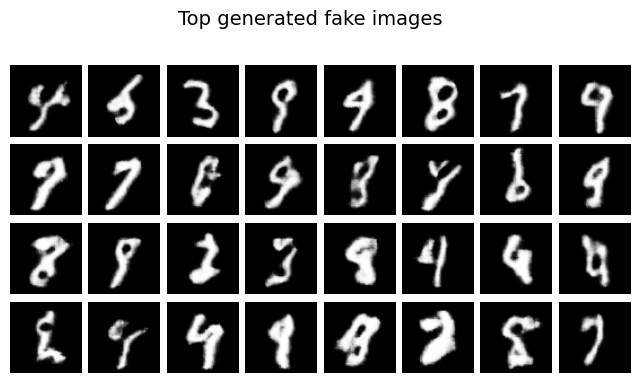

In [84]:
key, subkey = jr.split(key)
noise = jr.normal(subkey, (1000, latent_size, 1, 1))


@eqx.filter_jit
def evaluate(model, xx):
    out, _ = jax.vmap(model)(xx)
    return out


inference_gen = eqx.nn.inference_mode(generator)
inference_gen = eqx.Partial(inference_gen, state=generator_state)

generated_images = evaluate(inference_gen, noise)

inference_discriminator = eqx.nn.inference_mode(discriminator)
inference_discriminator = eqx.Partial(
    inference_discriminator, state=discriminator_state
)

logits = evaluate(inference_discriminator, generated_images)

plot_sample = generated_images[
    jax.lax.top_k(jax.nn.sigmoid(logits).squeeze(), 32)[1]
].transpose(0, 2, 3, 1)

fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(8, 4))
fig.suptitle("Top generated fake images", y=1.02, fontsize=14)

for ax, image in zip(sum(axes.tolist(), []), plot_sample):
    ax.imshow(image, cmap="gray")
    ax.set_axis_off()

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

They're still a bit fuzzy! Our model could probably do with some more training.